In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 1. Create the model architecture
num_classes = 2  # 1 class (plate) + background
model = fasterrcnn_resnet50_fpn(weights=None)  # no pretrained weights
in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)

# 2. Load the trained weights
model.load_state_dict(torch.load('C:/Users/thili/OneDrive/Desktop/NumberPlateDetection&Blur/Code/best_frcnn_lp_weights.pth', map_location='cpu'))

model.eval()  # set to evaluation mode

# 3. Now you can run inference safely


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [2]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
@torch.no_grad()
def predict_and_blur(img_path, conf_thr=0.5, blur=True):
    model.eval()
    
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.tensor(img_rgb / 255., dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
    
    # Get predictions
    outs = model(img_tensor)
    out = outs[0]
    
    boxes = out['boxes'].cpu().numpy()
    scores = out['scores'].cpu().numpy()
    keep = scores >= conf_thr
    boxes, scores = boxes[keep], scores[keep]

    vis = img.copy()
    for (x1,y1,x2,y2), sc in zip(boxes, scores):
        x1,y1,x2,y2 = map(int, [x1,y1,x2,y2])
        if blur:
            roi = vis[y1:y2, x1:x2]
            if roi.size>0:
                vis[y1:y2, x1:x2] = cv2.GaussianBlur(roi, (25,25), 30)
        else:
            cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(vis, f"plate {sc:.2f}", (x1,max(0,y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(Path(img_path).name)
    plt.axis('off')
    plt.show()


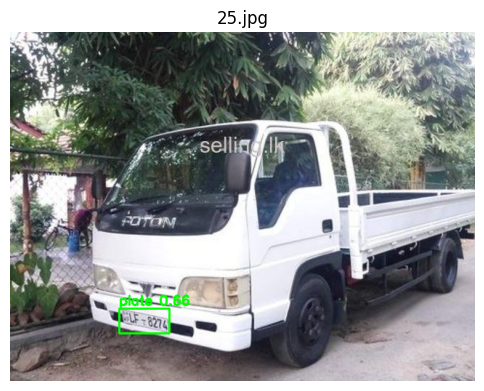

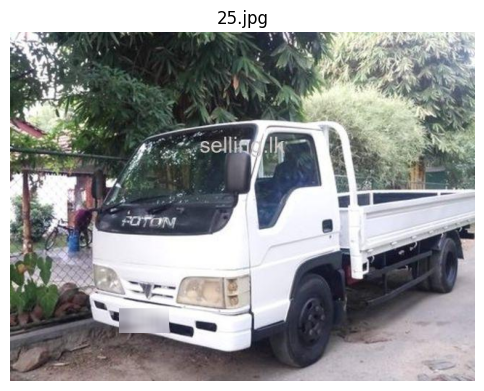

In [7]:
predict_and_blur("C:/Users/thili/OneDrive/Desktop/srilanka number plates/Numberplate/25.jpg", blur=False)
predict_and_blur("C:/Users/thili/OneDrive/Desktop/srilanka number plates/Numberplate/25.jpg", blur=True)